# Digit Recognizer - Intro to Convolution Neural Networks
The MNIST database of handwritten digits contains 60,000 images in the training, and 10,000 images in the test set. The digits have been size-normalized and centered in a fixed-size image of 28x28 pixels with a value between 0 and 255.

This dataset is often used for learning techniques and pattern recognition methods.

Kaggle does the work of flattening each 28x28 array of integers into a 1x784 row vector. Each column represents a single pixel and will be the features.

This notebook working through the tutorial found here: https://elitedatascience.com/keras-tutorial-deep-learning-in-python with additional info from http://cs231n.github.io/convolutional-networks/

In [25]:
import keras
import theano
import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

## Data Loading and Visualization


In [2]:
## load csv file into a dataframe. training set contains 42000 'images' each with 784 pixels
df = pd.read_csv(os.path.join('data','train.csv'))
print(df.shape)
# lets also isolate the label vector, y, which tells us which of the 10 digits the image represents
y = df['label']
X = df.drop(['label'],axis=1)
y.value_counts()

(42000, 785)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

(28, 28)


/Users/test/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show>

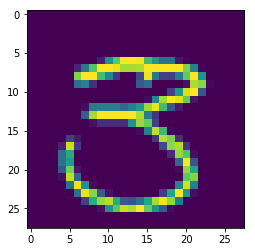

In [3]:
'''It is useful to plot out an image to get a feel for the data.  Let choose some image as an example. 
It needs to be reconstructed as a 28x28 image'''
image_num = 7
X0 = X.iloc[image_num].reshape(28,28)
print(X0.shape)
plt.imshow(X0)
plt.show

#### Convolution Networks work like regular neural networks but assume a 3D input (or an image). Neurons are arranged in 3D and every layer transforms 3D volumes to 3D volumes. The Convolution layer is the core building block of the network. The layer consists of a set of learnable filters. Each filter is convoled with the input. I think it is instructive to see some examples 2D convolution between our images and typical filters to get a feel for how this process works.
for this we will use pythons scipy singal processing library

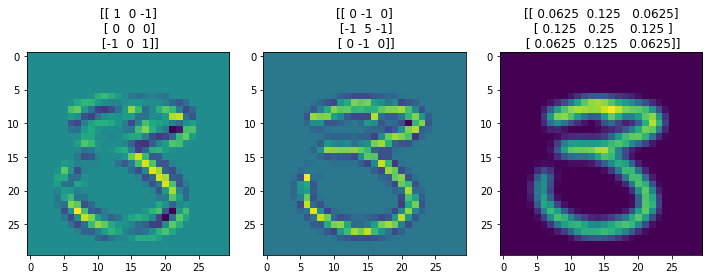

In [4]:
from scipy import signal
# Edge detection filter
EdgeDetection = np.array([[ 1, 0,  -1],
                          [0, 0, 0],
                        [ -1, 0,  1]])
# Sharpen Filter
Sharpen = np.array([[ 0, -1,  0],
                   [-1, 5, -1],
                    [ 0, -1,  0]]) 
# Gaussian Blue
GaussianBlur = np.array([[ 1/16, 1/8,  1/16],
                   [1/8, 1/4, 1/8],
                    [ 1/16, 1/8,  1/16]]) 
fig = plt.figure(figsize=(10, 5))
for index,item in enumerate([EdgeDetection,Sharpen,GaussianBlur]):
    convolution = signal.convolve2d(X0,item)
    plt.subplot(1,3,index+1)
    plt.imshow(convolution)
    plt.title(str(item))

fig.tight_layout()
plt.show()



## Data Preprocessing
While the row vectors provided by Kaggle for each image is the right shape for a regular neural network, for a Convolution network we actually want a shape (L,W,D), where L = W = 32 and D = 1.  In general D = 3 for the three color channels (red, blue, green)

In [5]:
# reshape 
X = X.as_matrix().reshape(X.shape[0],1,28,28)
print(X.shape)
print(y.shape)
# convert to float32 type and normalize such that values are between 0 and 1
X = X.astype('float32')
X /= 255
# split into a training set and a test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)


(42000, 1, 28, 28)
(42000,)


In [7]:
# Our class labels need to be converted from 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)
Y_train[:5]

(33600, 10)


array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Defining Model Architecture
The simpliest convolution NN is a sequence of layers. The main types of layers are the Convolutional Layer, Pooling Layer, and Fully-Connected Layer. The convolutional layer finds the convolution between the input and a set of learnable filters.  The pooling layer performs a downsampling on our volume and the fully-connected layer will compute the class score.

In [75]:
#sequential is a linear stack of layers
model = Sequential()

'''Start adding layers: the first argument in Convolution2D the number of filters (kernals) that are in this case 3x3 pixels.
the filters are a learned parameter in the algorithm.  setting this to 32 results in 32 "feature maps"
created from 32 different LEARNED features which are 3x3 pixels. Chose Rectified Linear unit (max(0,x)) 
as the activation function'''

model.add(Convolution2D(32, 3, 3,activation='relu', input_shape=(1,28,28),dim_ordering='th',border_mode='same'))
model.add(Convolution2D(32, 3, 3, activation='relu', dim_ordering='th',border_mode='same'))#second convolution layers
model.add(MaxPooling2D(pool_size=(2,2),dim_ordering='th')) #quarter the images by taking max of every 2x2 pixels
model.add(Dropout(0.25)) #regulariziation to prevent over fitting
# after a couple convolution and pooling layers we can convert our network into a more traditional NN, meaning 1D
model.add(Flatten()) #flatten image matrix into array for "normal" NN
model.add(Dense(128,activation='relu')) # a fully-connected hidden layer with 128 neurons
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) #final fully connecting layer with output the class score and therefore need 10 neurons
print(model.output_shape) 


(None, 10)


## Compile and fit model

In [76]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [77]:
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)

Epoch 1/10
33600/33600 [==============================] - 103s - loss: 0.2800 - acc: 0.9144   
Epoch 2/10
33600/33600 [==============================] - 111s - loss: 0.1079 - acc: 0.9681   
Epoch 3/10
33600/33600 [==============================] - 109s - loss: 0.0799 - acc: 0.9744   
Epoch 4/10
33600/33600 [==============================] - 107s - loss: 0.0668 - acc: 0.9788   
Epoch 5/10
33600/33600 [==============================] - 109s - loss: 0.0547 - acc: 0.9833   
Epoch 6/10
33600/33600 [==============================] - 107s - loss: 0.0487 - acc: 0.9849   
Epoch 7/10
33600/33600 [==============================] - 108s - loss: 0.0427 - acc: 0.9865   
Epoch 8/10
33600/33600 [==============================] - 109s - loss: 0.0396 - acc: 0.9873   
Epoch 9/10
33600/33600 [==============================] - 111s - loss: 0.0350 - acc: 0.9885   
Epoch 10/10
33600/33600 [==============================] - 110s - loss: 0.0331 - acc: 0.9888   


## Finally, evaluate the model on the test data

In [78]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [79]:
print(model.metrics_names[0],": ",score[0])
print(model.metrics_names[1],": ",score[1])

loss :  0.0437773161609
acc :  0.98880952381


In [80]:
'''Use the model to make predictions for each of the images in the test set'''
predictions = model.predict(X_test)
'''we can use classification_report to get statistics on each output class but we need to first covert it back into 
digits 0 - 9'''
print(classification_report(y_test,np.argmax(predictions,axis=1)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       826
          1       0.99      0.99      0.99       937
          2       0.98      1.00      0.99       836
          3       0.99      0.98      0.99       870
          4       0.99      0.99      0.99       814
          5       0.99      0.98      0.99       759
          6       1.00      0.99      0.99       827
          7       0.99      0.99      0.99       880
          8       0.99      0.99      0.99       813
          9       0.98      0.99      0.99       838

avg / total       0.99      0.99      0.99      8400



## Visualizing the outputs of the layers
It is worthwhile to try and visualize what is happening to an image as it goes through the CNN we have created. 

In [102]:
# choose some image from our test set to see how the CNN predicts the class
X = X_test[123:124]

In [107]:
#function we need to visualize layer outputs.  K.learning_phase should be turned off to turn dropout off
from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], model.layers[layer].output)
    activations = get_activations([X_batch,0])
    return activations

In [109]:
# let's remind ourselves of the layers in the CNN
model.layers

### Layer 0 : Convolution2D

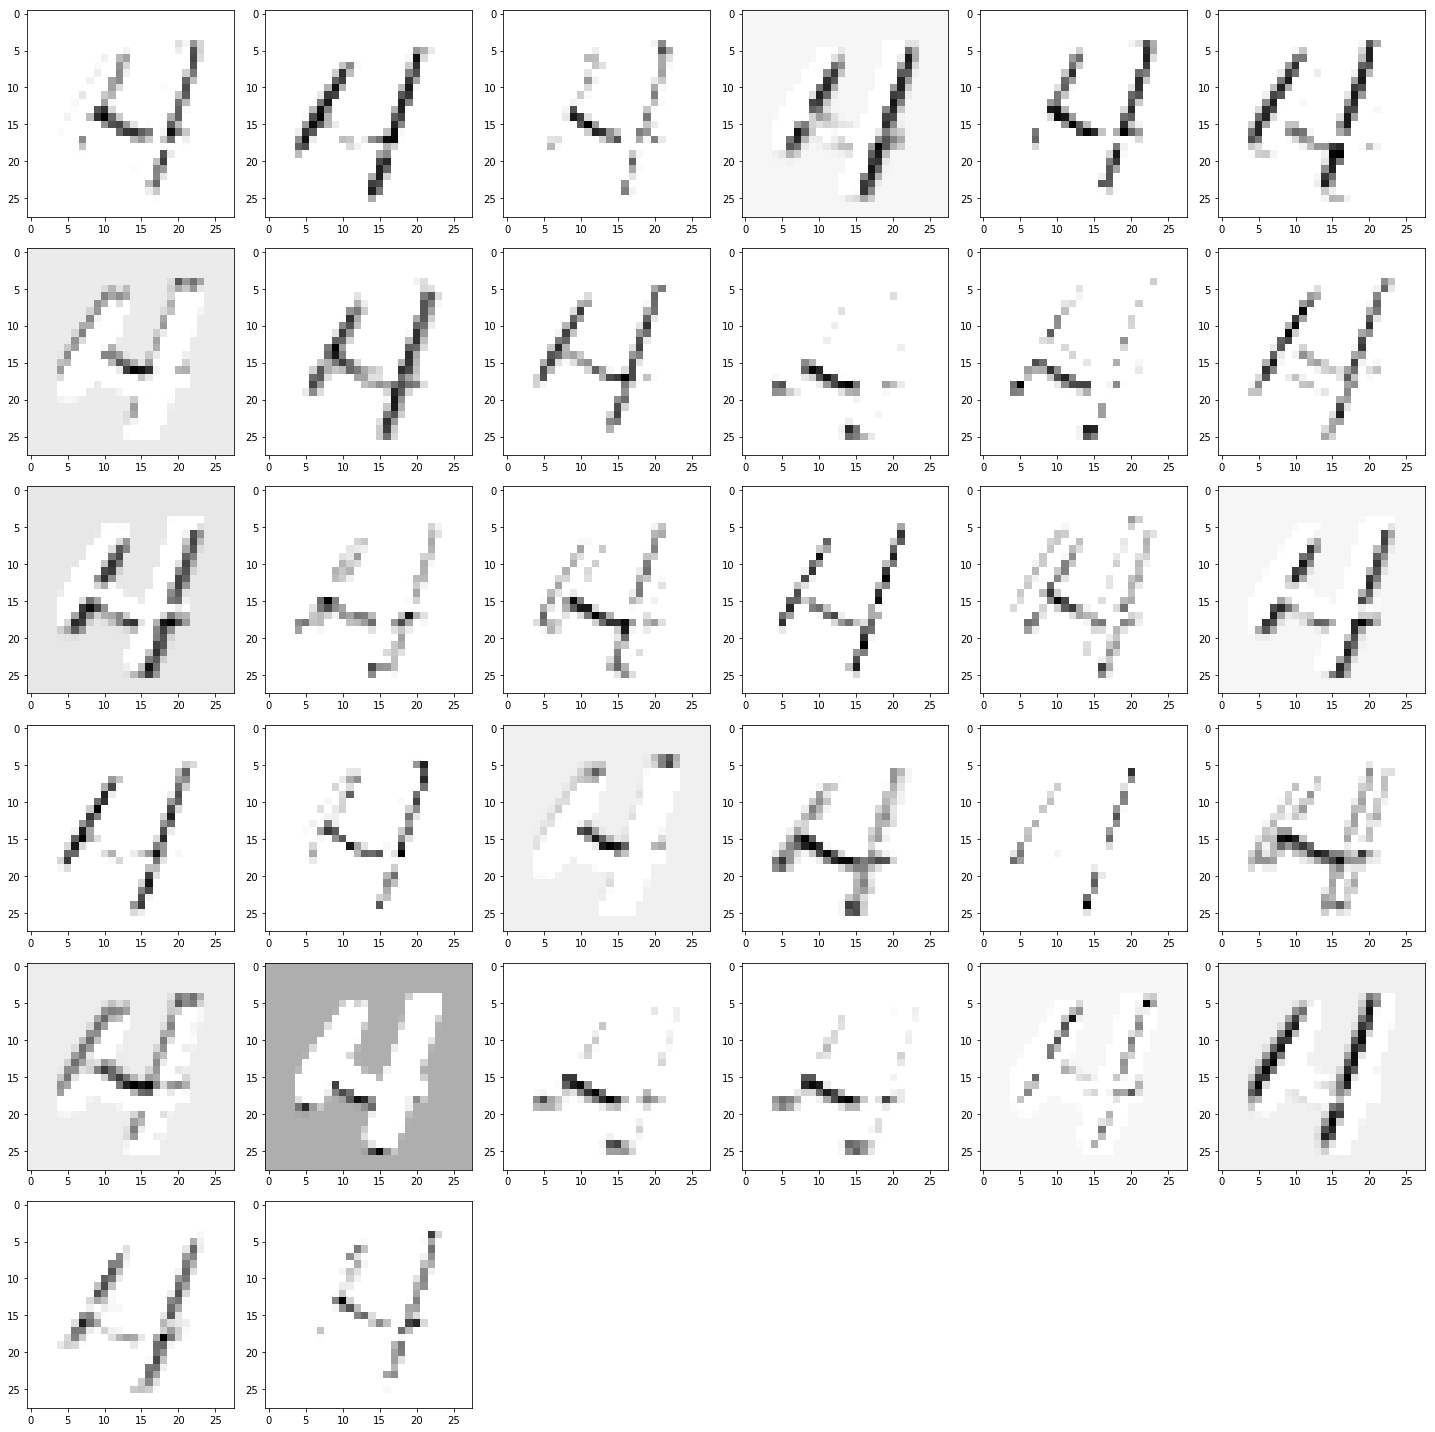

In [116]:
layer0 = get_activations(model,0,X)
layer0 = layer0.reshape(32,28,28)
fig = plt.figure(figsize=(20, 20))
for index in range(0,32):
    plt.subplot(6,6,index+1)
    plt.imshow(layer0[index],cmap='binary')

fig.tight_layout()
plt.show()

### layer1 : Convolution2D

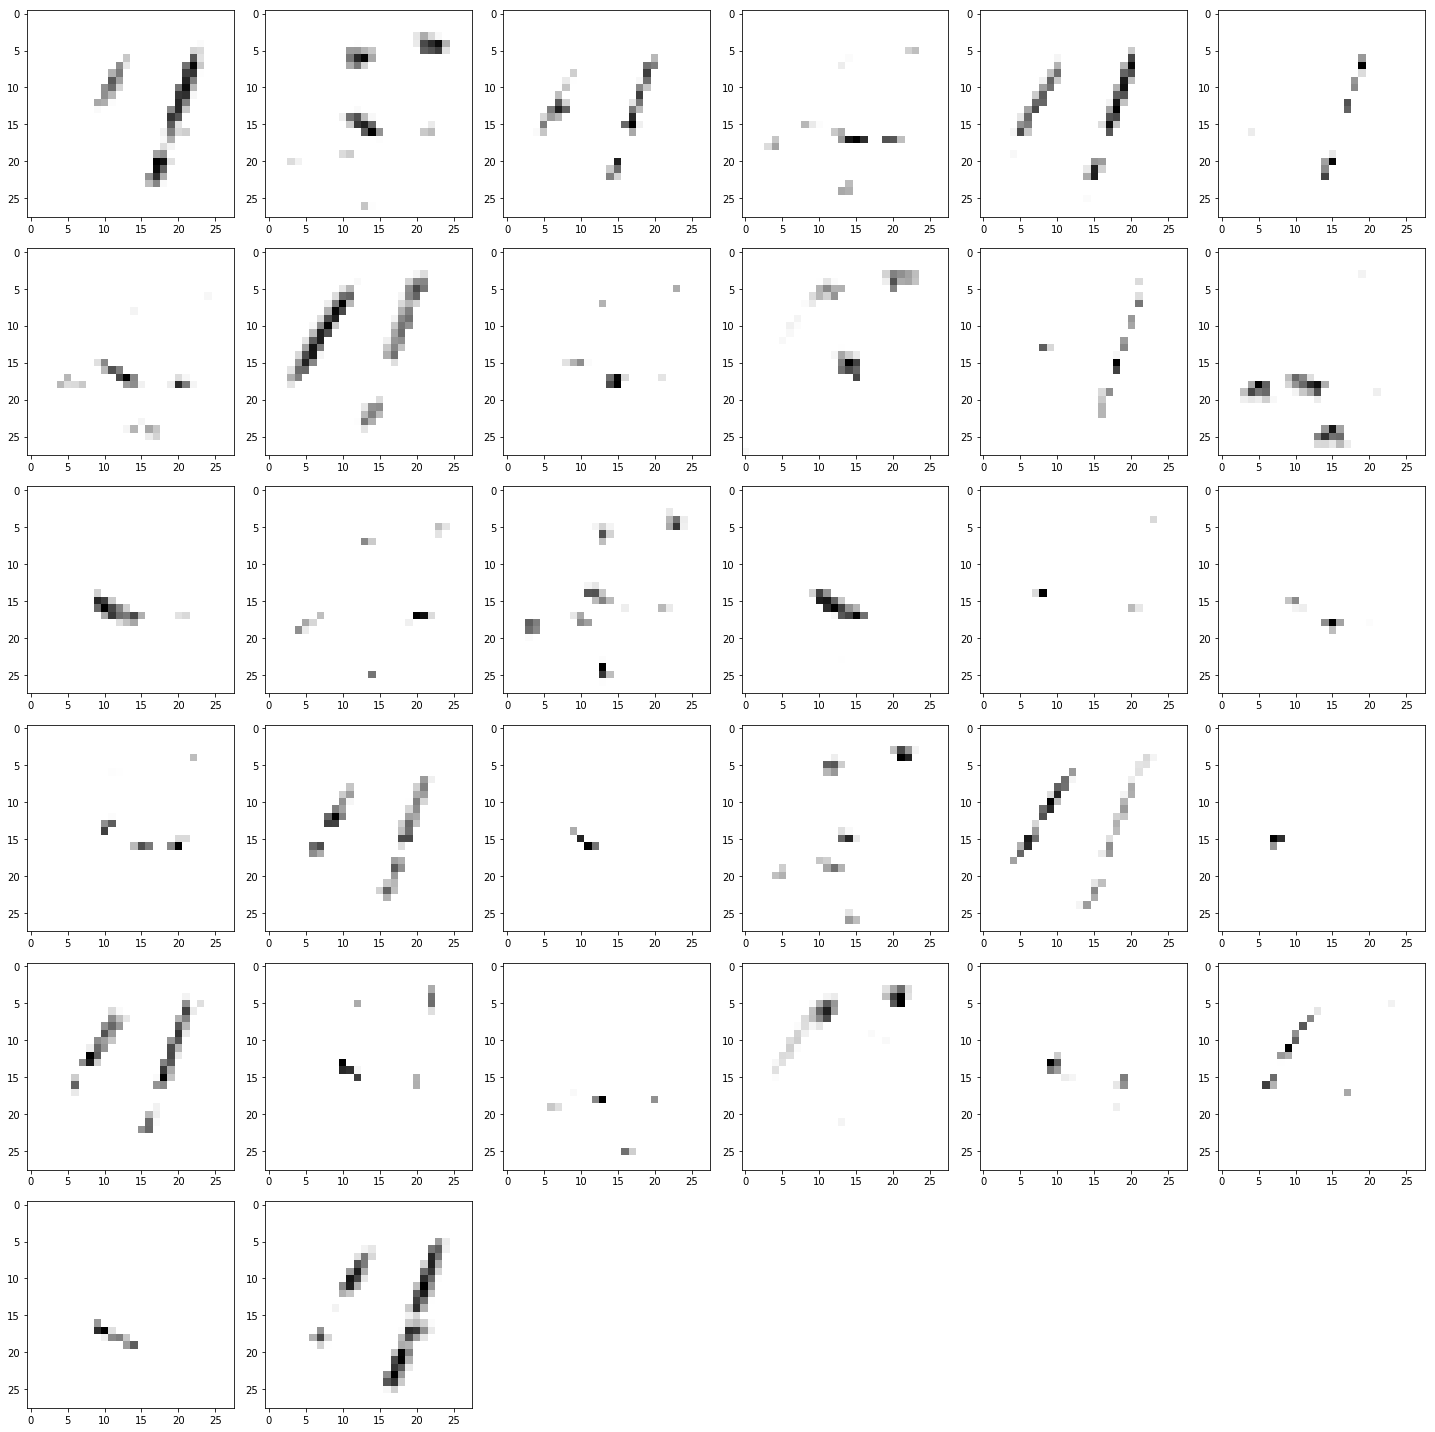

In [117]:
layer1 = get_activations(model,1,X)
layer1 = layer1.reshape(32,28,28)
fig = plt.figure(figsize=(20, 20))
for index in range(0,32):
    plt.subplot(6,6,index+1)
    plt.imshow(layer1[index],cmap='binary')

fig.tight_layout()
plt.show()

### Layer 2 : Max Pooling 2D

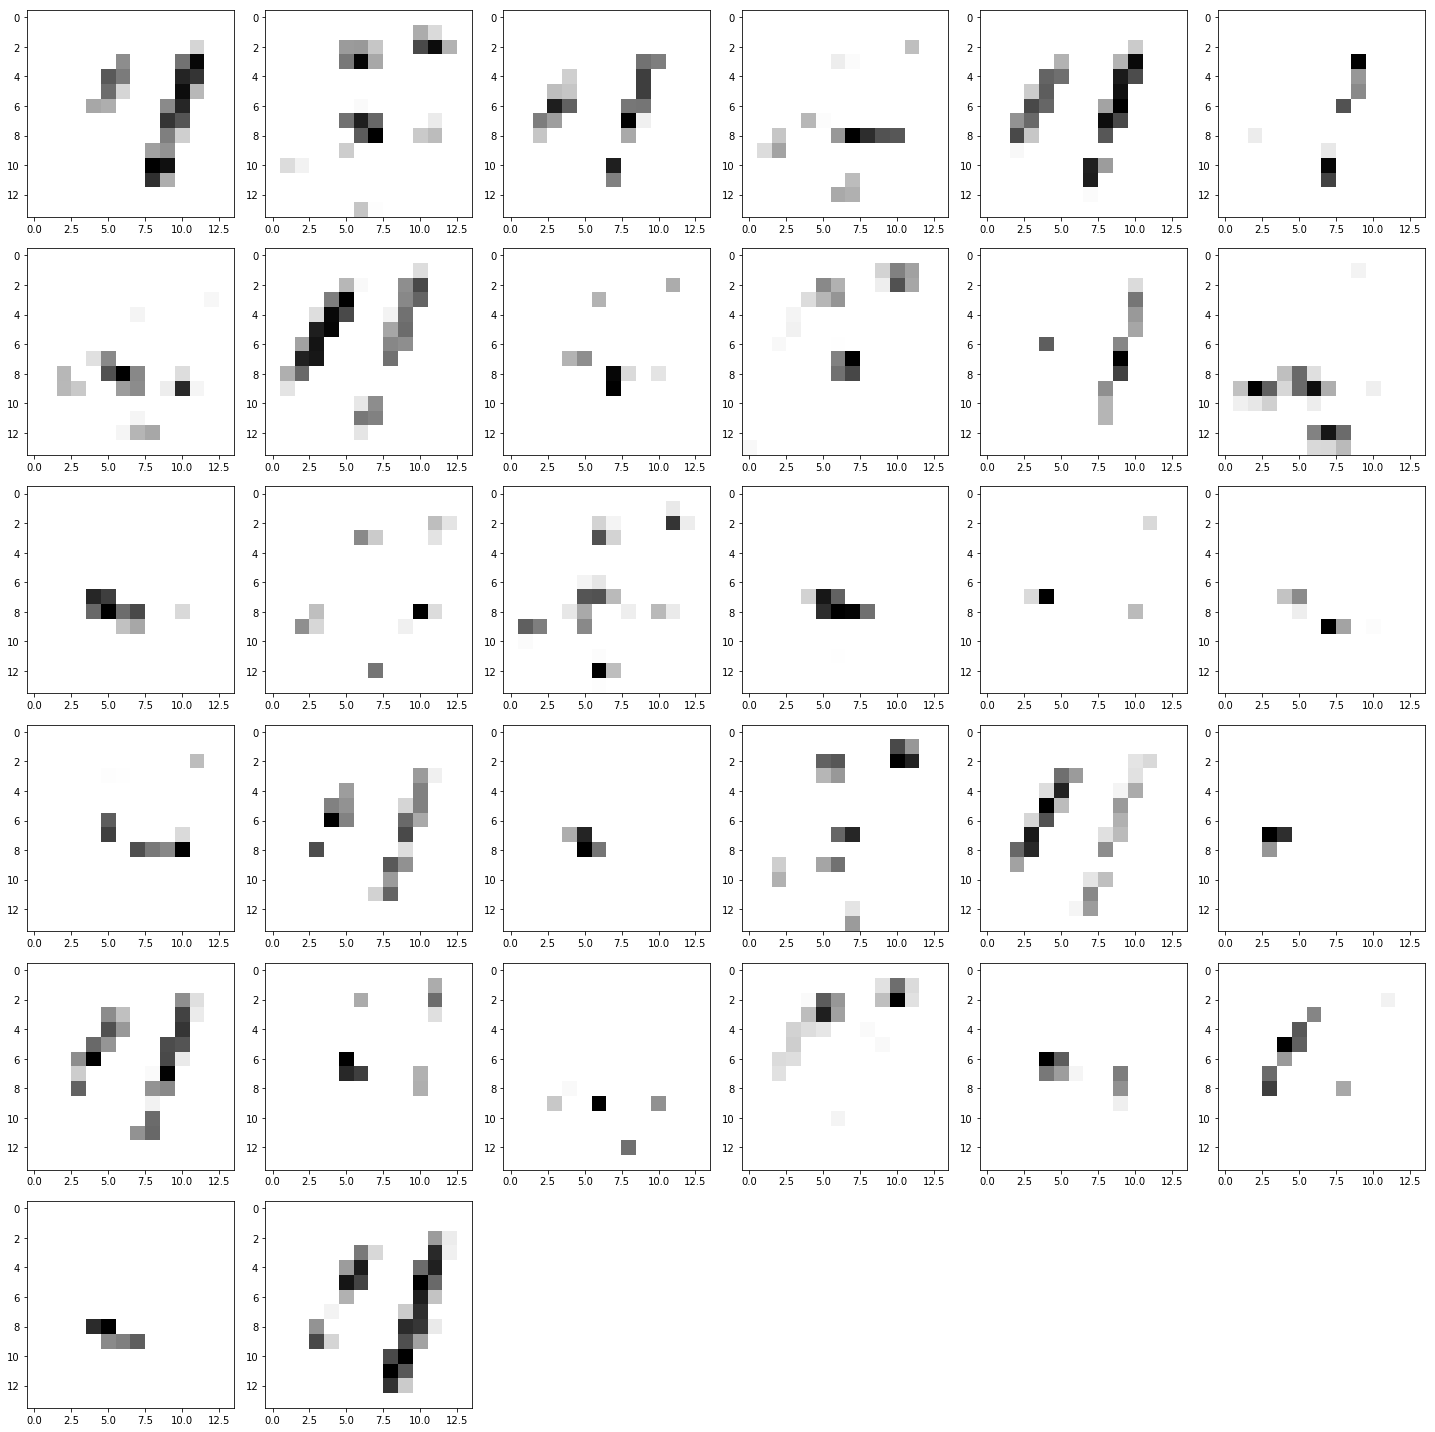

In [120]:
layer2 = get_activations(model,2,X)
layer2 = layer2.reshape(32,14,14)
fig = plt.figure(figsize=(20, 20))
for index in range(0,32):
    plt.subplot(6,6,index+1)
    plt.imshow(layer2[index],cmap='binary')

fig.tight_layout()
plt.show()

### Layer5 : Dense, fully connected layer after flattening

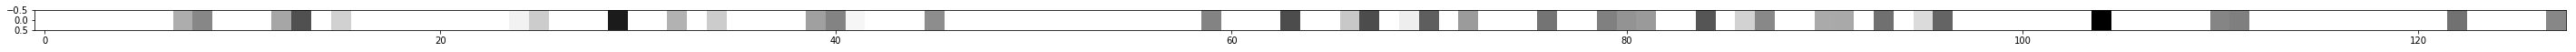

In [134]:
layer5 = get_activations(model,5,X)
fig = plt.figure(figsize=(50, 50))
plt.imshow(layer5,cmap='binary')
plt.show()

### Layer7: Dense, fully connecter layer. Final output

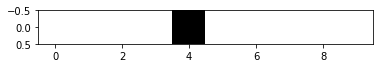

In [132]:
layer7 = get_activations(model,7,X)
plt.imshow(layer7,cmap='binary')
plt.show()